# Problem Definition

### I am given 3 years (2015-2017) of electricity load related data, including load, temperature, time. I am supposed to build a model to predict the probability of the hourly load being the daily peak.

In [1]:
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Pre-model Analysis

In [2]:
df_hist = pd.read_csv('load_hist_data.csv')
df_p = pd.read_csv('probability_estimates.csv')
df_weather = pd.read_csv('weather_data.csv')

# Convert 'date' column into datetime
df_weather['date'] = pd.to_datetime(df_weather.Date)
df_hist['date'] = pd.to_datetime(df_hist.Date)

df_hist.pop('Date')
df_weather.pop('Date')

0           1/1/2005
1           1/1/2005
2           1/1/2005
3           1/1/2005
4           1/1/2005
             ...    
981787    12/31/2008
981788    12/31/2008
981789    12/31/2008
981790    12/31/2008
981791    12/31/2008
Name: Date, Length: 981792, dtype: object

In [3]:
# First glance of the data
df_hist.head()

,Hour,Load,date
0,1,857,2005-01-01
1,2,825,2005-01-01
2,3,800,2005-01-01
3,4,794,2005-01-01
4,5,802,2005-01-01


In [4]:
df_weather.head()

,Hour,Station ID,Temperature,date
0,1,1,43,2005-01-01
1,2,1,41,2005-01-01
2,3,1,40,2005-01-01
3,4,1,39,2005-01-01
4,5,1,38,2005-01-01


In [5]:
# We checked that if there is any missing value in the given datasets
print (df_hist.isnull().sum())
print (df_weather.isnull().sum())

Hour    0
Load    0
date    0
dtype: int64
Hour           0
Station ID     0
Temperature    0
date           0
dtype: int64


In [6]:
# Check if all values for Hour is between 1 - 24
print(df_hist['Hour'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [7]:
# Check Load and temperature range, no non-sense or extreme values
print(df_hist['Load'].max(),df_hist['Load'].min())
print(df_weather['Temperature'].max(),df_weather['Temperature'].min())

2266 509
105 2


### We then merge 2 dataframes together by date and hour. Temperature measurements among different stations were aggregated to compute min and max values as new features.

In [8]:
merged_df = pd.merge(df_weather, df_hist, on=['date', 'Hour'])
df = merged_df.groupby(['date','Hour']).agg({'Temperature': ['min', 'max'], 'Load':'first'}).reset_index()
df.columns = ['date','Hour','Temp_min', 'Temp_max','Load']
df.head()

,date,Hour,Temp_min,Temp_max,Load
0,2005-01-01,1,39,53,857
1,2005-01-01,2,38,53,825
2,2005-01-01,3,37,52,800
3,2005-01-01,4,37,52,794
4,2005-01-01,5,37,51,802


### Here I do some data visualization: Based on visualization, it looks like a nonlinear model would be a good fit for this challenge.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


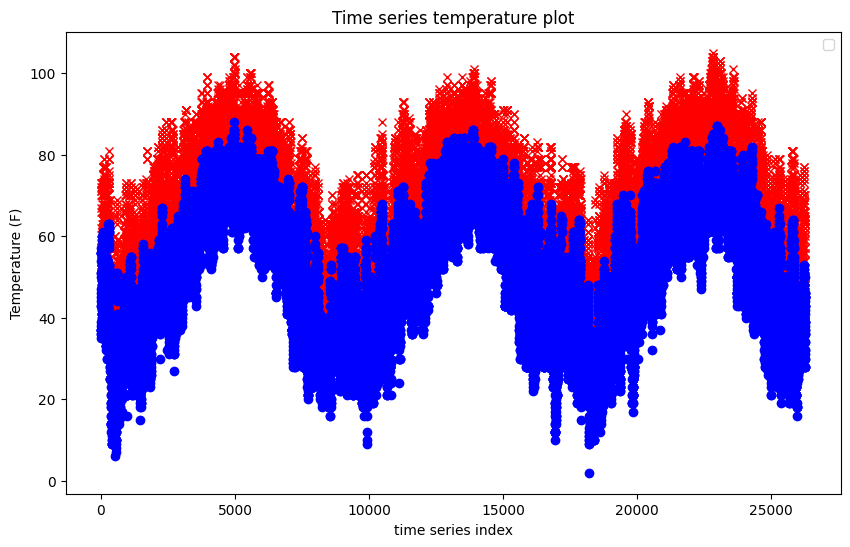

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.Temp_max, 'rx')
ax.plot(df.Temp_min, 'bo')

ax.set_title('Time series temperature plot')
ax.set_xlabel('time series index')
ax.set_ylabel('Temperature (F)')
ax.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


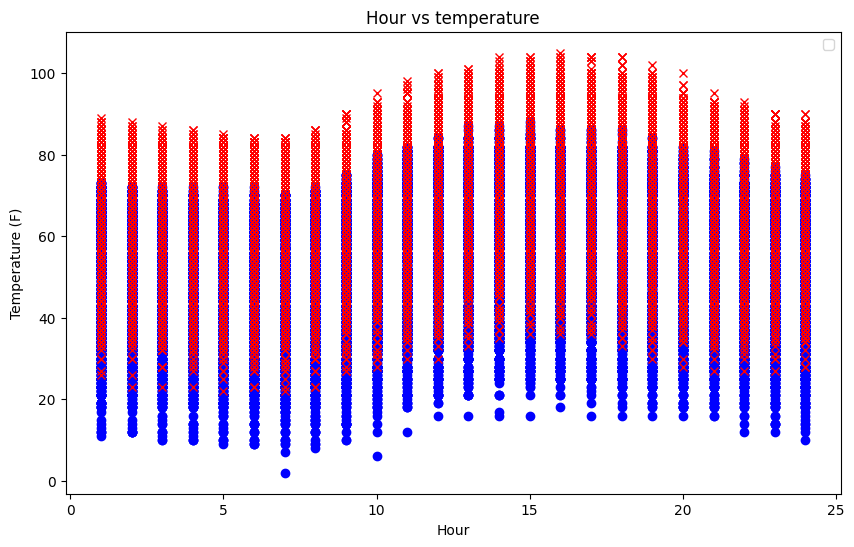

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.Hour,df.Temp_min, 'bo')
ax.plot(df.Hour, df.Temp_max, 'rx')

ax.set_title('Hour vs temperature')
ax.set_xlabel('Hour')
ax.set_ylabel('Temperature (F)')
ax.legend()


Text(0, 0.5, 'Load')

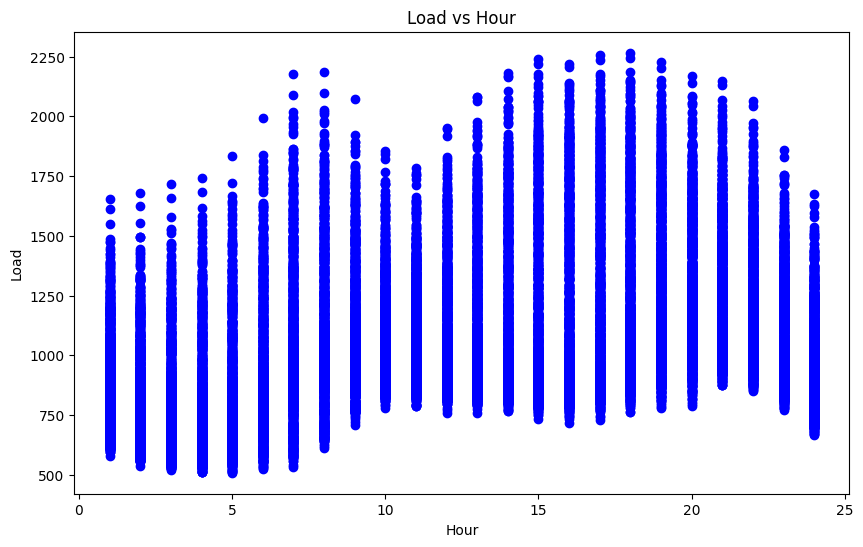

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.Hour,df.Load, 'bo')

ax.set_title('Load vs Hour')
ax.set_xlabel('Hour')
ax.set_ylabel('Load')


Text(0, 0.5, 'Load')

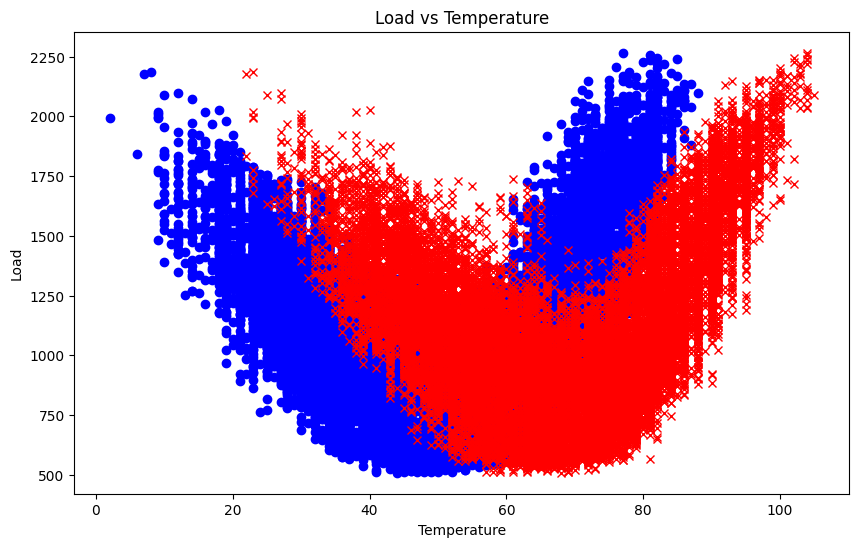

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.Temp_min,df.Load, 'bo')
ax.plot(df.Temp_max,df.Load, 'rx')

ax.set_title('Load vs Temperature')
ax.set_xlabel('Temperature')
ax.set_ylabel('Load')

### I found that there is a correlation between temperature and load. When it's very cold or hot, load will be high. When I compare the temperature vs hour plot and load vs hour plot, I found that they have similar pattern except that there is an extra peak at around 8am. Thus both temperature and hour features are necessary in this model. 

# Modeling and Feature Engineering

### I created key date-related features in our dataset:

#### Weekday Column: Indicates if a date is a weekday (1) or not (0).
#### US Holidays Column: Flags US holidays (1) or non-holidays (0).
#### WorkHour Columns: Binary indicators for each hour, highlighting whether it falls within standard working hours (1) or not (0)."

In [13]:
cal = USFederalHolidayCalendar()
df['IsHoliday'] = df.date.isin(cal.holidays())
df['IsWeekday'] = df.date.dt.weekday < 5
df['WorkHour'] = (df['Hour']>= 9) & (df['Hour']<= 17)

### I created a target column which indicates if each entry is peak hour of the day based on "Load"


In [14]:
df['peak'] = 0
max_load_indices = df.groupby('date')['Load'].idxmax()
df.loc[max_load_indices, 'peak'] = 1
df.head(24) # This ensures a peak entry for every set of 24 entries.

,date,Hour,Temp_min,Temp_max,Load,IsHoliday,IsWeekday,WorkHour,peak
0,2005-01-01,1,39,53,857,False,False,False,0
1,2005-01-01,2,38,53,825,False,False,False,0
2,2005-01-01,3,37,52,800,False,False,False,0
3,2005-01-01,4,37,52,794,False,False,False,0
4,2005-01-01,5,37,51,802,False,False,False,0
5,2005-01-01,6,36,50,828,False,False,False,0
6,2005-01-01,7,37,50,870,False,False,False,0
7,2005-01-01,8,36,51,916,False,False,False,0
8,2005-01-01,9,35,54,978,False,False,True,0
9,2005-01-01,10,43,59,988,False,False,True,1


### Here I generate cyclic data representation for hour, day and month, which can descibe the cyclic pattern of hour, day and month.

In [15]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/ 24)
df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
df.pop('Hour')
df.pop('month')
df.pop('day')
original_date = df.pop('date')
targetTotal = df.pop('peak')
targetLoad = df.pop('Load')

In [29]:
### I included features of min and max temperature of the previous hour in training (lag feature).

In [16]:
# Here I created lag data for temperature
lag_hours = 1

# Create lag features for 'Load' and 'Temperature'
for column in ['Temp_min','Temp_max']:
    for i in range(1, lag_hours + 1):
        df[f'{column}_lag_{i}'] = df[column].shift(i)

df_1 = df.dropna()
df_1.head()

,Temp_min,Temp_max,IsHoliday,IsWeekday,WorkHour,year,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,Temp_min_lag_1,Temp_max_lag_1
1,38,53,False,False,False,2005,0.500000,8.660254e-01,0.5,0.866025,0.201299,0.97953,39.0,53.0
2,37,52,False,False,False,2005,0.707107,7.071068e-01,0.5,0.866025,0.201299,0.97953,38.0,53.0
3,37,52,False,False,False,2005,0.866025,5.000000e-01,0.5,0.866025,0.201299,0.97953,37.0,52.0
4,37,51,False,False,False,2005,0.965926,2.588190e-01,0.5,0.866025,0.201299,0.97953,37.0,52.0
5,36,50,False,False,False,2005,1.000000,6.123234e-17,0.5,0.866025,0.201299,0.97953,37.0,51.0


### For train-test split, I used data before 2007/6/1 for training and anything after that for validation. Compared to splitting training and testing data randomly, this way of splitting can provent potential leakage.


In [17]:
separate_date = pd.to_datetime("2007-06-01")
train_index = original_date< separate_date 
test_index = ~train_index

X_train, X_test = df_1.loc[train_index], df_1.loc[test_index]
y_train, y_test = targetTotal.loc[X_train.index], targetTotal.loc[X_test.index]
y_train_load, y_test_load = targetLoad.loc[X_train.index], targetLoad.loc[X_test.index]

In [21]:
y_train

1        0
2        0
3        0
4        0
5        0
        ..
21136    0
21137    0
21138    0
21139    0
21140    0
Name: peak, Length: 21140, dtype: int64

## Approach 1
### The prediction target here was 0 or 1, where 0 means not a daily peak and 1 means daily peak.
### Random Forest classifier was used due to its nonlinear nature. From the previous Temperature vs Load plot, it is clear that their relationship is nonlinear. Since Load is directly related to our prediction target, a nonlinear model would be a better choice.
### I performed grid search for hyper parameter selection using mean squared error (mse) as a metric, which is directly related to the grading metrics provided by the assignment document.  



In [18]:

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

tscv = TimeSeriesSplit(n_splits=5)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Regressor
rf_classifier = RandomForestClassifier(class_weight=dict(zip(np.unique(y_train), class_weights)))

# Create the grid search
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the final model with the best parameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)
probabilities = best_model.predict_proba(X_test)
mse = mean_squared_error(probabilities[:,1], y_test)
print(f'Sum of Squared Error : {len(y_test)*mse}') #grading metrics provided in the assignment document

Sum of Squared Error : 157.62257976329477


### XGBoost is also performed to compare with Random Forest Classifier

In [19]:
# We have also tried to use XG boost
import xgboost as xgb

# Compute class weights
class_weights = {0: 24, 1: 1} 

# Create a XGBoost classifier
model = xgb.XGBClassifier(scale_pos_weight=class_weights[1])
model.fit(X_train, pd.DataFrame(y_train),sample_weight=y_train.map(class_weights))


probabilities = model.predict_proba(X_test)
mse = mean_squared_error(probabilities[:,1], y_test)
print(f'Sum of Squared Error (RMSE): {mse*len(y_test)}')

Sum of Squared Error (RMSE): 182.32529666810512


### Random forest classifier outperforms XGBoost by 30 squared error.

### Here I included lag feature with lag_hours = 5 for temperature

In [20]:

lag_hours = 5

# Create lag features for 'Load' and 'Temperature'
for column in ['Temp_min','Temp_max']:
    for i in range(2, lag_hours + 1):
        df[f'{column}_lag_{i}'] = df[column].shift(i)

df_5 = df.dropna()
df_5.head()

separate_date = pd.to_datetime("2007-06-01")
train_index = original_date< separate_date 
test_index = ~train_index

X_train, X_test = df_5.loc[train_index], df_5.loc[test_index]
y_train, y_test = targetTotal.loc[X_train.index], targetTotal.loc[X_test.index]
y_train_load, y_test_load = targetLoad.loc[X_train.index], targetLoad.loc[X_test.index]

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

tscv = TimeSeriesSplit(n_splits=5)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Regressor
rf_classifier = RandomForestClassifier(class_weight=dict(zip(np.unique(y_train), class_weights)))

# Create the grid search
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the final model with the best parameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)
probabilities = best_model.predict_proba(X_test)
mse = mean_squared_error(probabilities[:,1], y_test)
print(f'Sum of Squared Error : {len(y_test)*mse}') #grading metrics provided in the assignment document

Sum of Squared Error : 150.3273471682675


### Here I created second lag feature with lag_hours = 10 for temperature

In [21]:

lag_hours = 10

# Create lag features for 'Load' and 'Temperature'
for column in ['Temp_min','Temp_max']:
    for i in range(6, lag_hours + 1):
        df[f'{column}_lag_{i}'] = df[column].shift(i)

df_10 = df.dropna()
df_10.head()

separate_date = pd.to_datetime("2007-06-01")
train_index = original_date< separate_date 
test_index = ~train_index

X_train, X_test = df_10.loc[train_index], df_10.loc[test_index]
y_train, y_test = targetTotal.loc[X_train.index], targetTotal.loc[X_test.index]
y_train_load, y_test_load = targetLoad.loc[X_train.index], targetLoad.loc[X_test.index]



# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

tscv = TimeSeriesSplit(n_splits=5)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Regressor
rf_classifier = RandomForestClassifier(class_weight=dict(zip(np.unique(y_train), class_weights)))

# Create the grid search
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the final model with the best parameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)
probabilities = best_model.predict_proba(X_test)
mse = mean_squared_error(probabilities[:,1], y_test)
print(f'Sum of Squared Error : {len(y_test)*mse}') #grading metrics provided in the assignment document

Sum of Squared Error : 151.14914005566067


### Here I created another lag feature with lag_hours=24 for temperature

In [22]:

lag_hours = 24

# Create lag features for 'Load' and 'Temperature'
for column in ['Temp_min','Temp_max']:
    for i in range(11, lag_hours + 1):
        df[f'{column}_lag_{i}'] = df[column].shift(i)

df_24 = df.dropna()
df_24.head()

separate_date = pd.to_datetime("2007-06-01")
train_index = original_date< separate_date 
test_index = ~train_index

X_train, X_test = df_24.loc[train_index], df_24.loc[test_index]
y_train, y_test = targetTotal.loc[X_train.index], targetTotal.loc[X_test.index]
y_train_load, y_test_load = targetLoad.loc[X_train.index], targetLoad.loc[X_test.index]


# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

tscv = TimeSeriesSplit(n_splits=5)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Regressor
rf_classifier = RandomForestClassifier(class_weight=dict(zip(np.unique(y_train), class_weights)))

# Create the grid search
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the final model with the best parameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)
probabilities = best_model.predict_proba(X_test)
mse = mean_squared_error(probabilities[:,1], y_test)
print(f'Sum of Squared Error : {len(y_test)*mse}') #grading metrics provided in the assignment document

Sum of Squared Error : 153.46529523465952


### By trying with different lag features, I found that the best score achieved so far is 150, which is achieved by lag_hours = 5.

# Approach 2
### In this following trail, I first trained a model to predict load, then I generated a result column by setting the daily maximum load to be 1 and the others to be 0. In another word, the result is not directly predicted from a model, but generated based on a model which predicts the numerical values of load.

In [23]:

tscv = TimeSeriesSplit(n_splits=5)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Regressor
tf_regressor = RandomForestRegressor()

# Create the grid search
grid_search = GridSearchCV(estimator=tf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)

# Fit the grid search to the data
grid_search.fit(X_train, y_train_load)

best_params = grid_search.best_params_

# Train the final model with the best parameters
best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train, y_train_load)
predicted_load = best_model.predict(X_test)

r2 score is: 0.9193068263287996


Text(0, 0.5, 'Actual load')

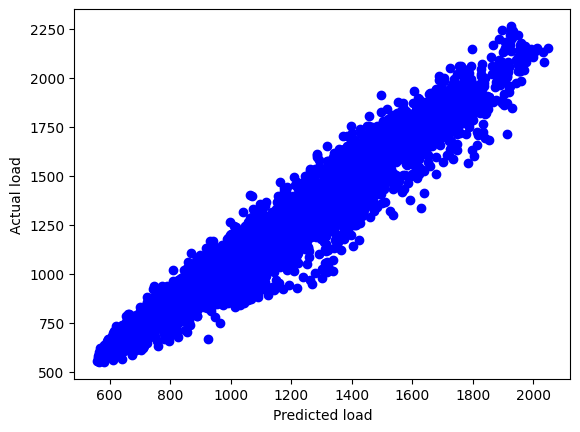

In [24]:
r2 = r2_score(y_test_load, predicted_load)
print ('r2 score is: '+ str(r2))
fig, ax = plt.subplots()

ax.plot(predicted_load,y_test_load, 'bo')

ax.set_xlabel('Predicted load')
ax.set_ylabel('Actual load')

### The 0.9 R2 score shows that our prediction on load values are pretty accurate

In [25]:
test_date = original_date[test_index]
df_predicted = pd.DataFrame({'test_date': test_date, 'predicted_test': predicted_load})
df_predicted['peak'] = 0
max_load_indices = df_predicted.groupby('test_date')['predicted_test'].idxmax()
df_predicted.loc[max_load_indices, 'peak'] = 1
df_predicted.head(48)
mse = mean_squared_error(df_predicted['peak'], y_test)
print(f'Sum of Squared Error : {len(y_test)*mse}') #grading metrics provided in the assignment document

Sum of Squared Error : 300.0


### This approach ended up with worse score (318).
### I also tried to generate results by 1) applying min/max normalization and 2) calculate rank probability respectively as blow

In [26]:
scaler = MinMaxScaler()
df_predicted['scaled_predicted_test'] = df_predicted.groupby(df_predicted['test_date'].dt.date)['predicted_test'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
df_predicted['probability'] = df_predicted.groupby(df_predicted['test_date'].dt.date)['predicted_test'].rank(pct=True)

In [27]:
mse = mean_squared_error(df_predicted['scaled_predicted_test'], y_test)
print(f'Sum of Squared Error : {len(y_test)*mse}') 
mse = mean_squared_error(df_predicted['probability'], y_test)
print(f'Sum of Squared Error : {len(y_test)*mse}') 
#grading metrics provided in the assignment document

Sum of Squared Error : 1731.3383246499739
Sum of Squared Error : 1640.0677083333337


### The score only got much worse with these approaches.


# Approach 3
### I also tried to build another model. I predicted load in the same way as I did in Approach 2. Then I train another classification model inlcuding load values as a feature to predict probability.

In [29]:
X_test['load'] = predicted_load
X_train['load'] = y_train_load
lag_hours = 1
for i in range(1,lag_hours+1):
    X_train['Load_lag_1'] = X_train['load'].shift(i)
    
for i in range(1,lag_hours+1):
    X_test['Load_lag_1'] =    X_test['load'].shift(i)
    
# X_train = X_train.dropna()
X_test['Load_lag_1'].iloc[0] = X_train['load'].iloc[-1]
X_train['peak'] = y_train
X_train.dropna(inplace = True)
y_train = X_train.pop('peak')

/var/folders/z1/8t1tf76x2gj1fb7cfw0trmfw0000gn/T/ipykernel_55111/3411384084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['load'] = predicted_load
/var/folders/z1/8t1tf76x2gj1fb7cfw0trmfw0000gn/T/ipykernel_55111/3411384084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['load'] = y_train_load
/var/folders/z1/8t1tf76x2gj1fb7cfw0trmfw0000gn/T/ipykernel_55111/3411384084.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [30]:

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

tscv = TimeSeriesSplit(n_splits=5)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [10, 50, 100],
    
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Regressor
rf_classifier = RandomForestClassifier(class_weight=dict(zip(np.unique(y_train), class_weights)))

# Create the grid search
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the final model with the best parameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)
probabilities = best_model.predict_proba(X_test)
mse = mean_squared_error(probabilities[:,1], y_test)
print(f'Sum of Squared Error (RMSE): {mse*len(y_test)}')

Sum of Squared Error (RMSE): 154.47192766220022


### This approach also did not achieve the score as good as the Approach 1. I proceeded with Approach 1. 

### Generate probability of each hour of the following year (2008) being the peak load hour of the day with the model I built in Approach 1.

In [32]:

X_train = df_5
y_train = targetTotal[df_5.index]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

tscv = TimeSeriesSplit(n_splits=5)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Regressor
rf_classifier = RandomForestClassifier(class_weight=dict(zip(np.unique(y_train), class_weights)))

# Create the grid search
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the final model with the best parameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50)

In [33]:
df_p['date'] = pd.to_datetime(df_p.Date)
df_p.pop('Date')
df = df_weather.groupby(['date','Hour']).agg({'Temperature': ['min', 'max']}).reset_index()
df.columns = ['date','Hour','Temp_min', 'Temp_max']
df.head()

,date,Hour,Temp_min,Temp_max
0,2005-01-01,1,39,53
1,2005-01-01,2,38,53
2,2005-01-01,3,37,52
3,2005-01-01,4,37,52
4,2005-01-01,5,37,51


In [37]:
cal = USFederalHolidayCalendar()
df['IsHoliday'] = df.date.isin(cal.holidays())
df['IsWeekday'] = df.date.dt.weekday < 5
df['WorkHour'] = (df['Hour']>= 9) & (df['Hour']<= 17)


# Here I created lag data for temperature
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/ 24)
df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

lag_hours = 5
for column in ['Temp_min','Temp_max']:
    for i in range(1, lag_hours + 1):
        df[f'{column}_lag_{i}'] = df[column].shift(i)

df_5_pred = df.dropna()

merged_df_pred = pd.merge(df_5_pred, df_p, on=['date', 'Hour'])

merged_df_pred.pop('Hour')
merged_df_pred.pop('month')
merged_df_pred.pop('day')
merged_df_pred.pop('date')

merged_df_pred.pop('Daily Peak Probability')

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
8779   NaN
8780   NaN
8781   NaN
8782   NaN
8783   NaN
Name: Daily Peak Probability, Length: 8784, dtype: float64

In [38]:
merged_df_pred

,Temp_min,Temp_max,IsHoliday,IsWeekday,WorkHour,year,hour_sin,hour_cos,month_sin,month_cos,...,Temp_min_lag_1,Temp_max_lag_1,Temp_min_lag_2,Temp_min_lag_3,Temp_min_lag_4,Temp_min_lag_5,Temp_max_lag_2,Temp_max_lag_3,Temp_max_lag_4,Temp_max_lag_5
0,32,49,True,True,False,2008,2.588190e-01,0.965926,5.000000e-01,0.866025,...,32.0,48.0,32.0,34.0,30.0,37.0,49.0,49.0,48.0,50.0
1,30,47,True,True,False,2008,5.000000e-01,0.866025,5.000000e-01,0.866025,...,32.0,49.0,32.0,32.0,34.0,30.0,48.0,49.0,49.0,48.0
2,30,46,True,True,False,2008,7.071068e-01,0.707107,5.000000e-01,0.866025,...,30.0,47.0,32.0,32.0,32.0,34.0,49.0,48.0,49.0,49.0
3,28,46,True,True,False,2008,8.660254e-01,0.500000,5.000000e-01,0.866025,...,30.0,46.0,30.0,32.0,32.0,32.0,47.0,49.0,48.0,49.0
4,30,47,True,True,False,2008,9.659258e-01,0.258819,5.000000e-01,0.866025,...,28.0,46.0,30.0,30.0,32.0,32.0,46.0,47.0,49.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,21,43,False,True,False,2008,-8.660254e-01,0.500000,-2.449294e-16,1.000000,...,23.0,45.0,25.0,27.0,28.0,28.0,48.0,51.0,57.0,61.0
8780,19,41,False,True,False,2008,-7.071068e-01,0.707107,-2.449294e-16,1.000000,...,21.0,43.0,23.0,25.0,27.0,28.0,45.0,48.0,51.0,57.0
8781,19,39,False,True,False,2008,-5.000000e-01,0.866025,-2.449294e-16,1.000000,...,19.0,41.0,21.0,23.0,25.0,27.0,43.0,45.0,48.0,51.0
8782,19,37,False,True,False,2008,-2.588190e-01,0.965926,-2.449294e-16,1.000000,...,19.0,39.0,19.0,21.0,23.0,25.0,41.0,43.0,45.0,48.0


In [39]:
result = best_model.predict_proba(merged_df_pred)[:,1]
df_p['Daily Peak Probability'] = result
df_p.to_csv('probability_estimates_XL.csv')

0.0
0.0
0.008275862068965517
0.07127586206896551
0.02152970533855682
0.017349081364829398
0.17198111599686403
0.4068473555430075
0.10083333333333332
0.031166666666666662
0.004
0.0
0.025666666666666664
0.03899999999999999
0.02
0.02238095238095238
0.04333333333333333
0.08771825396825396
0.14109920634920634
0.16557905982905982
0.4012380952380953
0.07442857142857143
0.028571428571428567
0.04857142857142858
0.011333333333333332
0.0
0.02238095238095238
0.006666666666666666
0.004
0.0
0.19376190476190477
0.5382380952380954
0.08166666666666668
0.045
0.04
0.04
0.02
0.028999999999999998
0.035666666666666666
0.028999999999999998
0.028999999999999998
0.08044444444444444
0.1361111111111111
0.14677777777777778
0.21177777777777776
0.01
0.0
0.0
0.0
0.0
0.02
0.06333333333333332
0.047
0.052000000000000005
0.3441666666666666
0.8141818181818182
0.062181818181818185
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.013333333333333332
0.016666666666666666
0.026666666666666665
0.06833333333333333
0.07933333333333334
0.0
0.0
0.01

# Summary

### In this study, the initial steps involved data cleaning and exploratory data analysis (EDA). During EDA, I observed a non-linear correlation between temperature and load, prompting the choice of a tree-based model for the subsequent analysis. 

### Moving on to feature engineering, cyclic features were created for date-time stamps. Each entry was enriched with maximum and minimum temperature values for each station. Additionally, lag features for temperature (1h, 5h, 10h, and 24h) were introduced. The model was trained on data before 2007/6/1, with validation performed on data after that date.

### In the modeling phase, the inclusion of a 1h temperature lag feature led to the random forest classifier outperforming XGBoost, yielding a validation sum of squared error of 158. Subsequently, incorporating 5h, 10h, and 24h lag features improved the model's performance. Notably, the introduction of 5h lag data resulted in the lowest validation sum of squared error (149) among all configurations.

### An alternative approach was explored using a random forest regressor to predict load and identifying peak hours based on the predicted load values. Despite achieving an impressive r2 value of ~0.9, the sum of squared error was found to be larger compared to the classifiers. I additionally explored converting the predicted load into a probability using two methods: (1) applying min-max normalization to the daily load data and (2) assigning weights to hourly load values, ensuring the daily sum of weights equaled to 1. Despite these attempts, both approaches resulted in a significantly larger sum of squared error compared to the random forest classifier.


# Future directions:

### Since the current approach generates good predictions, the furthur implementation of neural network was not preceeded. Nonetheless, two promising deep learning approaches have caught my attention, each offering potential improvements to the current results. 

### The first model involves representing date-time information using a model-agnostic vector representation known as Time2Vec. Notably, Kazemi et al. demonstrated enhanced model performance through the application of Time2Vec, showcasing its potential benefits.

### In a separate study, Choi et al. introduced an interpretable deep learning model that combines an attention mechanism with gated recurrent units for energy-related time-series forecasting. This approach offers the advantage of determining an adaptable encoding length for electricity load prediction, presenting an intriguing avenue for further exploration.